In [1]:
import sys, os, time
import numpy as np

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from estimators.statistical_descriptor import Nagler_WS
# from plot.figure_roc import ROC_plot
from utils.dataset_management import load_train, load_test, parser_pipeline, BFold
from utils.dataset_load import  save_h5_II, load_data_h5, load_info_h5, shuffle_data, Dataset_loader
from utils.files_management import (
    load_yaml,
    dump_pkl,
    init_logger,
    open_param_set_dir,
    report_prediction,
    report_metric_from_log,
    write_report,
)


In [2]:

#def Nagler_estimation(data_path):
def Nagler_estimation(X_trainU, y_train, X_test, y_test, label_encoder):
    y_est_save = {}
    '''X_trainU, y_train, label_encoder = load_train(
        data_path, -1, balanced=False, shffle=True, encode=True
    )
    X_test, y_test = load_test(
        data_path, -1, balanced=True, shffle=True, encoder=label_encoder
    )
    '''
    pos_class = label_encoder.transform(["wet"])[0]

    NGS_VV = Nagler_WS(bands=6)
    name_pip = "Nagler_VV"
    prob_test = NGS_VV.predict_proba(X_test)[:, pos_class]
    prob_train = NGS_VV.predict_proba(X_trainU)[:, pos_class]
    y_prob = np.concatenate([prob_train, prob_test])
    y_true = np.concatenate([y_train, y_test])

    y_est_save[name_pip] = {"y_true": y_true, "y_est": y_prob}

    NGS_VH = Nagler_WS(bands=7)
    name_pip = "Nagler_VH"
    prob_test = NGS_VH.predict_proba(X_test)[:, pos_class]
    prob_train = NGS_VH.predict_proba(X_trainU)[:, pos_class]
    y_prob = np.concatenate([prob_train, prob_test])
    y_true = np.concatenate([y_train, y_test])

    y_est_save[name_pip] = {"y_true": y_true, "y_est": y_prob}

    return y_est_save


In [3]:
param_path = "../parameter/config_pipeline.yml"
pipeline_param = load_yaml(param_path)

match pipeline_param["type"]:
    case "local":
        local_param_path = "../parameter/config_data_local.yml"
        data_param = load_yaml(local_param_path)
    case "global":
        global_param_path = "pipeline/parameter/config_data_global.yml"
        data_param = load_yaml(global_param_path)
    case _:
        f"no such type : {pipeline_param["type"]}"

try:
    data_path = "../data/dataset/dataset_AD_08200821_14Mas3Top3Phy_W15_corrected.h5"
    out_dir = pipeline_param["out_dir"]
    seed = pipeline_param["seed"]
    BANDS_MAX = pipeline_param["BANDS_MAX"]
except KeyError as e:
    print("KeyError: %s undefine" % e)

start_line = 0

# y_nagler = Nagler_estimation(data_path)
# print(y_nagler)

dtst_ld = Dataset_loader(
    data_path,
    shuffle=False,
)
dtst_ld.infos

,date,massif,aquisition,aquisition2,elevation,slope,orientation,tmin,tel,hsnow,target
0,2020-12-25,ARAVIS,ASC,ASC,900.0,20.0,45.0,-2.896717,0.166419,3.488328,0
1,2020-12-25,ARAVIS,ASC,ASC,900.0,20.0,45.0,-2.896717,0.166419,3.488328,0
2,2020-12-25,ARAVIS,ASC,ASC,1200.0,45.0,225.0,-4.667171,0.024536,0.336520,0
3,2020-12-25,ARAVIS,ASC,ASC,1200.0,45.0,135.0,-5.906706,0.156946,2.868350,0
4,2020-12-25,ARAVIS,ASC,ASC,1200.0,45.0,135.0,-5.906706,0.156946,2.868350,0
...,...,...,...,...,...,...,...,...,...,...,...
1288436,2021-01-05,HTE-MAURIE,DSC,DSC,3000.0,45.0,180.0,-20.930857,0.518277,0.000000,0
1288437,2021-01-05,HTE-MAURIE,DSC,DSC,3000.0,20.0,45.0,-21.431910,0.980208,0.000000,0
1288438,2021-01-05,HTE-MAURIE,DSC,DSC,2400.0,45.0,45.0,-18.423183,0.614442,0.000000,0
1288439,2021-01-05,HTE-MAURIE,DSC,DSC,2400.0,20.0,0.0,-18.984406,0.452196,0.000000,0


In [4]:
print(dtst_ld.infos.head())  # Check the first few rows and column names

        date  massif aquisition aquisition2  elevation  slope  orientation  \
0 2020-12-25  ARAVIS        ASC         ASC      900.0   20.0         45.0   
1 2020-12-25  ARAVIS        ASC         ASC      900.0   20.0         45.0   
2 2020-12-25  ARAVIS        ASC         ASC     1200.0   45.0        225.0   
3 2020-12-25  ARAVIS        ASC         ASC     1200.0   45.0        135.0   
4 2020-12-25  ARAVIS        ASC         ASC     1200.0   45.0        135.0   

       tmin       tel     hsnow  target  
0 -2.896717  0.166419  3.488328       0  
1 -2.896717  0.166419  3.488328       0  
2 -4.667171  0.024536  0.336520       0  
3 -5.906706  0.156946  2.868350       0  
4 -5.906706  0.156946  2.868350       0  


<Axes: >

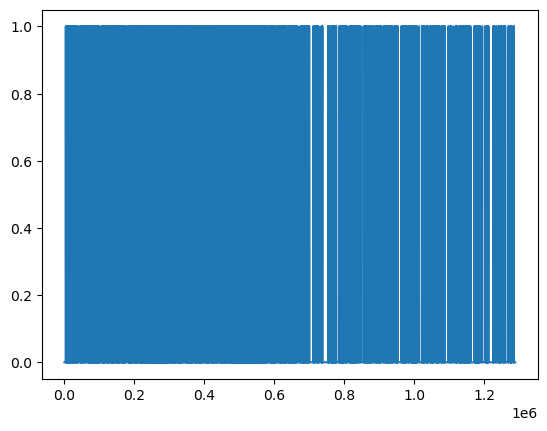

In [8]:
dtst_ld.infos["target"].plot()

In [6]:
# Example of request
rq1 = "massif == 'VERCORS' and \
        ((date.dt.month == 3 and date.dt.day== 1) or \
        (elevation > 3000 and hsnow < 0.25))"

rq2 = "massif == 'ARAVIS' & aquisition == 'ASC' & \
        elev == 900.0 & slope == 20 & theta == 45 "

rq3 = 'massif == "ARAVIS"'

x, y = dtst_ld.request_data(rq1)

Request: massif == 'VERCORS' and         ((date.dt.month == 3 and date.dt.day== 1) or         (elevation > 3000 and hsnow < 0.25)) with 197 samples
(197, 15, 15, 9)


In [7]:
X_trainU, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

# Assuming you have a label encoder from your existing pipeline
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_nagler = Nagler_estimation(X_trainU, y_train_encoded, X_test, y_test_encoded, label_encoder)
print(y_nagler)




ValueError: Found input variables with inconsistent numbers of samples: [197, 3]